# 🌍 **Air Quality Index (AQI) Prediction Model** 

##  Predicting & Analyzing Air Quality Trends  

This model uses historical pollution data to forecast AQI levels, helping identify pollution patterns and potential risks over time.

In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

### 🔍 Loading & Inspecting the Dataset  

We begin by loading the dataset and analyzing its structure to understand column names, data types, and missing values.

In [2]:
# Load the dataset
df = pd.read_csv("../data/dataset.csv", encoding="ISO-8859-1", low_memory=False)
print(df.head())

  stn_code       sampling_date           state   location agency  \
0      150  February - M021990  Andhra Pradesh  Hyderabad    NaN   
1      151  February - M021990  Andhra Pradesh  Hyderabad    NaN   
2      152  February - M021990  Andhra Pradesh  Hyderabad    NaN   
3      150     March - M031990  Andhra Pradesh  Hyderabad    NaN   
4      151     March - M031990  Andhra Pradesh  Hyderabad    NaN   

                                 type  so2   no2  rspm  spm  \
0  Residential, Rural and other Areas  4.8  17.4   NaN  NaN   
1                     Industrial Area  3.1   7.0   NaN  NaN   
2  Residential, Rural and other Areas  6.2  28.5   NaN  NaN   
3  Residential, Rural and other Areas  6.3  14.7   NaN  NaN   
4                     Industrial Area  4.7   7.5   NaN  NaN   

  location_monitoring_station  pm2_5        date  
0                         NaN    NaN  1990-02-01  
1                         NaN    NaN  1990-02-01  
2                         NaN    NaN  1990-02-01  
3       

## 📅 Extracting Date Features

To enhance the predictive power of our model, we extract key date-based features from the dataset:

- **Convert `date` column to DateTime format** for easy manipulation.
- **Extract `year`, `month`, and `day`** to capture seasonal and yearly trends.
- **Compute `day_of_week`** (0 = Monday, 6 = Sunday) to analyze weekly patterns.
- **Create `is_weekend` feature** (1 if it's Saturday or Sunday, otherwise 0) to differentiate pollution levels on weekends vs. weekdays.


In [3]:
# Convert Date to Datetime & Extract Features
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

The following function calculates the **Air Quality Index (AQI)** based on major pollutants using **Central Pollution Control Board (CPCB) breakpoints**.


### Methodology:
- The function takes a row of pollutant data as input.
- It checks pollutant concentrations against predefined **breakpoints** (ranges for different AQI levels).
- The **sub-index** for each pollutant is calculated using linear interpolation.
- The **maximum sub-index** among all pollutants is taken as the final AQI.

In [4]:
# CPCB AQI Calculation using all major pollutants
def calculate_aqi(row):
    breakpoints = {
        'pm2_5': [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200), (91, 120, 201, 300), (121, 250, 301, 400)],
        'pm10': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200), (251, 350, 201, 300), (351, 430, 301, 400)],
        'no2': [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200), (181, 280, 201, 300), (281, 400, 301, 400)],
        'so2': [(0, 40, 0, 50), (41, 80, 51, 100), (81, 380, 101, 200), (381, 800, 201, 300), (801, 1600, 301, 400)],
        'co': [(0, 1, 0, 50), (1.1, 2, 51, 100), (2.1, 10, 101, 200), (10.1, 17, 201, 300), (17.1, 34, 301, 400)],
        'o3': [(0, 50, 0, 50), (51, 100, 51, 100), (101, 168, 101, 200), (169, 208, 201, 300), (209, 748, 301, 400)]
    }
    
    sub_indices = []
    for pollutant, bps in breakpoints.items():
        if pollutant in row:
            value = row[pollutant]
            for c_low, c_high, i_low, i_high in bps:
                if c_low <= value <= c_high:
                    sub_index = ((i_high - i_low) / (c_high - c_low)) * (value - c_low) + i_low
                    sub_indices.append(sub_index)
                    break
    
    return max(sub_indices) if sub_indices else np.nan
# Apply AQI calculation to dataset
df['AQI'] =df.apply(calculate_aqi, axis=1)

## 🎯 Selecting Features & Target for AQI Prediction

To train our AQI prediction model, we define:

- **Features (`X`)**: The independent variables used for prediction.
- **Target (`y`)**: The dependent variable (AQI) that we aim to predict.

### 📌 Selected Features:
1. **Time-based Features:**
   - `year`, `month`, `day`: Capture seasonal variations in AQI.
   - `day_of_week`: Helps in analyzing weekly pollution trends.
   - `is_weekend`: Identifies differences between weekday and weekend AQI.

2. **Pollutant Features:**
   - `so2` (Sulfur Dioxide)
   - `no2` (Nitrogen Dioxide)
   - `pm2_5` (Fine Particulate Matter)  
   These pollutants have a **direct impact** on air quality.

In [5]:
# Select Features & Target
features = ['year', 'month', 'day', 'day_of_week', 'is_weekend', 'so2', 'no2', 'pm2_5']
target = 'AQI'
X = df[features]
y = df['AQI']

## 🔧 Handling Missing Values

Missing data can negatively impact model performance, so we apply appropriate imputation techniques:

### 📌 Strategy:
1. **For Features (`X`)**:
   - Use `SimpleImputer` with `median` strategy.
   - Replaces missing values in numerical columns with the median of each column.
   - **Why?** The median is robust against outliers compared to the mean.

2. **For Target (`y`)**:
   - Use `.fillna(y.median())` to replace missing AQI values with the median.

In [6]:
# Handle missing values
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)
y = y.fillna(y.median())


## ✂️ Splitting Data for Training & Testing

To evaluate the model effectively, we split the dataset into training and testing sets:

### 📌 Strategy:
- **80% Training Data (`X_train`, `y_train`)**: Used to train the model.
- **20% Testing Data (`X_test`, `y_test`)**: Used to assess model performance.
- **`random_state=42`**: Ensures reproducibility of results.

In [7]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 🌲 Hyperparameter Tuning & Model Training

To optimize our **Random Forest Regressor**, we use **RandomizedSearchCV** to find the best hyperparameters and train the model.

### 🔍 Step 1: Hyperparameter Tuning
We define a **parameter grid** for tuning:
- `n_estimators`: Number of trees in the forest.
- `max_depth`: Maximum depth of each tree.
- `min_samples_split`: Minimum samples required to split a node.
- `min_samples_leaf`: Minimum samples required at a leaf node.
- `bootstrap`: Whether to use bootstrapped samples.

We use **RandomizedSearchCV** for hyperparameter tuning:
```python
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Define parameter grid
param_dist = {
    'n_estimators': [50, 100, 200, 300],  
    'max_depth': [None, 10, 20, 30],     
    'min_samples_split': [2, 5, 10],      
    'min_samples_leaf': [1, 2, 4],        
    'bootstrap': [True, False]            
}

# Initialize model
rf = RandomForestRegressor(random_state=42)

# Perform Randomized Search
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, 
                                   n_iter=10, cv=5, scoring='neg_mean_squared_error', 
                                   verbose=2, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Get best parameters
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)


## 🚀 Step 2: Train the Model with Best Hyperparameters

After tuning, we train the **Random Forest Regressor** with the best-found hyperparameters to predict AQI.


In [8]:
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train model with best hyperparameters
best_rf = RandomForestRegressor(
    n_estimators=50, 
    min_samples_split=5, 
    min_samples_leaf=1, 
    max_depth=30, 
    bootstrap=True, 
    random_state=42
)

# Fit the model
best_rf.fit(X_train, y_train)

# Make predictions
y_pred = best_rf.predict(X_test)


In [9]:
# Predictions
y_pred =best_rf.predict(X_test)

## 📊 Model Evaluation Results & Interpretation

After training the model, we analyze its performance using three key metrics:  

### 1️⃣ Mean Absolute Error (MAE)  
- MAE represents the average absolute difference between the actual and predicted AQI values.  
- It provides a simple measure of prediction accuracy without considering the direction of errors.  
- **Lower MAE** means the model is making more accurate predictions.

### 2️⃣ Root Mean Squared Error (RMSE)  
- RMSE is similar to MAE but **penalizes larger errors more heavily** by squaring them before averaging.  
- It provides a clearer picture of how much predictions deviate from actual values on average.  
- **Lower RMSE** means fewer large deviations in predictions.

### 3️⃣ R² Score (Coefficient of Determination)  
- R² measures how well the model explains the variability in AQI values.  
- It ranges from **0 to 1**, where **1 means perfect predictions** and **0 means the model has no predictive power**.  
- **Higher R²** means the model is better at explaining AQI trends.

📌 **Key Insights:**  
- If **MAE and RMSE are low**, the model is making precise predictions.  
- If **R² is close to 1**, the model explains AQI trends well.  
- If **errors are high or R² is low**, the model may need improvements like hyperparameter tuning or better feature selection.

✅ *These metrics help determine if the model is suitable for AQI forecasting!* 🎯


In [10]:
# Evaluate Model
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))

MAE: 0.09939014876399635
RMSE: 1.141327362522169
R² Score: 0.9978419891218963


### 🌟 **Feature Importance**  

This table shows how important each feature (pollutant levels, date-related info) is in predicting AQI.

In [11]:
# Create a DataFrame to store feature importance values
feature_importances = pd.DataFrame({
    'Feature': features,  # Feature names
    'Importance': best_rf.feature_importances_  # Importance scores from the trained model
})

# Print the features sorted by importance (highest first)
print(feature_importances.sort_values(by='Importance', ascending=False))


       Feature  Importance
6          no2    0.778480
7        pm2_5    0.176468
5          so2    0.043530
0         year    0.000810
2          day    0.000338
1        month    0.000218
3  day_of_week    0.000143
4   is_weekend    0.000013


### 🔍 **Feature Importance Visualization**  

This bar chart shows how important each feature is in predicting AQI using the Random Forest model.  

📌 **What This Means:**  
✔️ Higher bars indicate features that have a greater impact on AQI predictions.  
✔️ Lower bars suggest features that contribute less to the model.  

This helps us focus on the most significant factors affecting air quality.

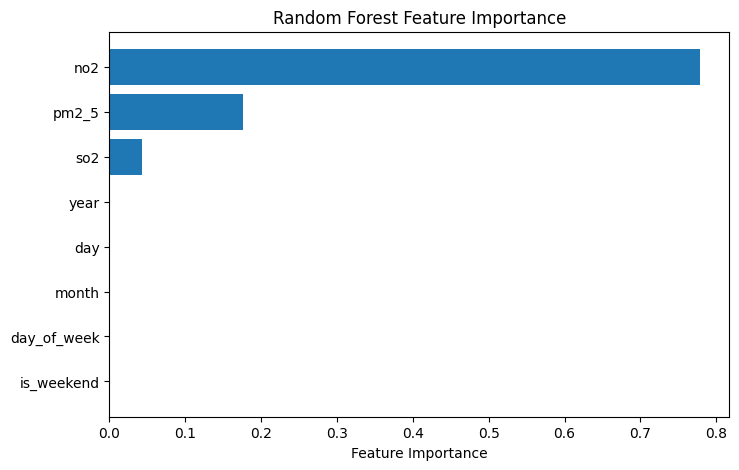

In [12]:
# Get feature importance values from the trained model
feature_importance = best_rf.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importance)

# Create a horizontal bar chart
plt.figure(figsize=(8, 5))
plt.barh(np.array(features)[sorted_idx], feature_importance[sorted_idx])  # Plot sorted feature importance
plt.xlabel("Feature Importance")  # Label for x-axis
plt.title("Random Forest Feature Importance")  # Title of the plot
plt.show()  # Display the chart


## 🔮 Future AQI Predictions (2025-2035)

- Generated **hypothetical** pollutant levels (SO₂, NO₂, PM2.5) for **April (2025-2035)**.  
- Included **time-based features** (day, weekday, weekends).  
- Used the trained **Random Forest model** to predict **future AQI**.  

📌 *This hypothetical data helps analyze trends and plan for future air quality management.*  


In [13]:

# Set seed for reproducibility
np.random.seed(42)

# Generate dates for April from 2025 to 2035
years = np.repeat(np.arange(2025, 2036), 30)  # 30 days for each year
days = np.tile(np.arange(1, 31), 11)  # Repeat days for 11 years
months = [4] * len(years)  # April is month 4
day_of_week = days % 7  # Generate weekday info
is_weekend = [1 if d % 7 >= 5 else 0 for d in days]  # Identify weekends

# Generate random pollutant levels within realistic ranges
so2 = np.random.uniform(5, 20, len(years))   # SO2 levels (5-20)
no2 = np.random.uniform(10, 50, len(years))  # NO2 levels (10-50)
pm2_5 = np.random.uniform(30, 80, len(years))  # PM2.5 levels (30-80)

# Create DataFrame
future_dates = pd.DataFrame({'year': years, 'month': months, 'day': days,
                             'day_of_week': day_of_week, 'is_weekend': is_weekend,
                             'so2': so2, 'no2': no2, 'pm2_5': pm2_5})

# Predict AQI using trained model
future_dates['Predicted_AQI'] = best_rf.predict(future_dates)


c:\Users\sriva\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


📌 *Check the output for detailed predictions.*

In [14]:

# Show Future AQI Predictions
print(future_dates)


     year  month  day  day_of_week  is_weekend        so2        no2  \
0    2025      4    1            1           0  10.618102  24.238907   
1    2025      4    2            2           0  19.260715  40.313844   
2    2025      4    3            3           0  15.979909  10.575740   
3    2025      4    4            4           0  13.979877  14.642906   
4    2025      4    5            5           1   7.340280  11.840106   
..    ...    ...  ...          ...         ...        ...        ...   
325  2035      4   26            5           1  16.068454  15.103212   
326  2035      4   27            6           1  13.315311  21.351036   
327  2035      4   28            0           0  14.175811  24.523292   
328  2035      4   29            1           0  11.294001  35.836690   
329  2035      4   30            2           0   8.715965  32.831132   

         pm2_5  Predicted_AQI  
0    47.804836      79.724138  
1    79.325762     162.733084  
2    60.288741     100.000000  
3    41

## 📈 Predicted AQI Trend (2025-2035)  

This graph visualizes the **future AQI predictions** for April from **2025 to 2035** using the trained model.  

- **X-axis:** Represents the **year** from 2025 to 2035.  
- **Y-axis:** Shows the **predicted AQI values** for each year.  
- **Trend Line:** Helps in identifying patterns in air quality over time.  

📌 *This can be useful for tracking pollution trends and planning air quality management strategies.*  


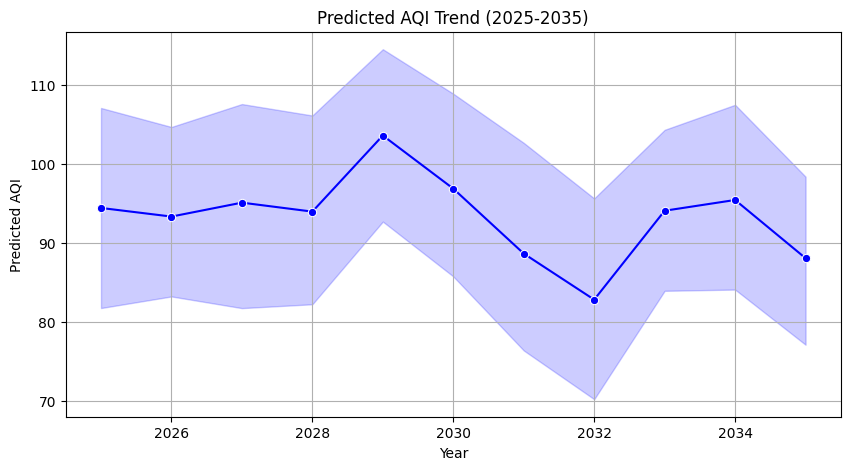

In [15]:
# Plot Predicted AQI Trend from 2025 to 2035
plt.figure(figsize=(10, 5))  # Set figure size

# Line plot for predicted AQI values
sns.lineplot(x=future_dates['year'], y=future_dates['Predicted_AQI'], marker='o', color='b')

# Add title and labels for better readability
plt.title("Predicted AQI Trend (2025-2035)")  # Set plot title
plt.xlabel("Year")  # X-axis represents the years
plt.ylabel("Predicted AQI")  # Y-axis represents the predicted AQI values

# Add grid for better visualization
plt.grid(True)

# Show the plot
plt.show()


### 💾 **Saving the Trained AQI Prediction Model**  

This code saves the trained Random Forest model so it can be reused later without retraining.  

📌 **Why Save the Model?**  
✔️ Saves time by avoiding retraining.  
✔️ Can be loaded later for predictions on new data.  
✔️ Useful for deployment in applications or APIs.

In [16]:
import os
import pickle

# Define the model directory path relative to the current working directory
model_dir = os.path.join(os.getcwd(), "../model/")  

# Convert to an absolute path for consistency
model_dir = os.path.abspath(model_dir)  

# Ensure the directory exists (create if missing)
os.makedirs(model_dir, exist_ok=True)  

# Define the full path for saving the model
model_path = os.path.join(model_dir, "aqi_model.pkl")  

# Open the file in write-binary mode and save the model using pickle
with open(model_path, "wb") as f:
    pickle.dump(best_rf, f)  

# Confirm the model has been saved successfully
print(f"Model saved at: {model_path}")  


Model saved at: c:\Users\sriva\TrainIT\TrainIT\model\aqi_model.pkl
